# **Nuclear power and air pollution**

Group name: The Bug Slayerz

Group members:

Bologa Nicolae (901121)

Barbato Daniele (883661)

Nica Sergiu (874965)

Pantano Alice (883502)

Air pollution stands as the foremost environmental health risk globally and serves as a significant contributor to environmental deterioration, posing a threat to numerous ecosystems. Air pollutants arising from human activity overwhelmingly derive from energy production and use. The combustion of fossil fuels and biomass accounts for the majority of emissions, particularly in the case of sulfur dioxide and nitrogen oxides released into the atmosphere. According to the IPCC (Intergovernmental Panel on Climate Change), nuclear power has been appointed as the fastest approach to reach an affordable, reliable, low-carbon energy future, holding the highest mitigation potential with the lowest average cost in the energy supply sector among the variety of electricity generation technologies. Nuclear reactors generate electricity without the harmful byproducts that coal, oil and natural gas emit, making it an attractive option to mitigate climate change.

Considering that energy demand is expected to drastically rise in the next 20 years, the danger that the levels of greenhouse gases will also increase made us question whether electricity generated by nuclear power might actually be a sustainable alternative for the future. Therefore, with our project we wanted to investigate whether a positive association exists between nuclear-generated electricity and the corresponding levels of air pollution for countries in Europe. Do those countries producing and relying on nuclear-generated electricity have lower levels of air pollution?


# **Importing libraries**

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import geopandas as gpd
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import glob
from sklearn.impute import SimpleImputer
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline allows the resulting plots of Matplotlib to be displayed directly in the notebook, rather than in a separate window or file
%matplotlib inline

ModuleNotFoundError: No module named 'geopandas'

# **The geolocation of all power plants in Europe**

When referring to the electricity generated by nuclear reactors, the terms "nuclear power" and "nuclear energy" are often used interchangeably.
A power plant encompasses the entire facility responsible for electricity generation, housing potentially more than a nuclear reactor, the device necessary to initiate and control the nuclear fission. While our analysis will specifically take account of the number of nuclear reactors, we first decided to have a look at the geolocalization of power plants in Europe.

The dataset used for this section of the research is the Global Power Plant Database, a comprehensive open source database of power plants around the world, provided by the World Resources Institute (WRI), a global research non-profit organization.

**Source:**
> L. Byers, J. Friedrich, R. Hennig, A.
Kressig, Li X., C. McCormick, and L. Malaguzzi Valeri. 2021.
“A Global Database of Power Plants.” Washington, DC:
World Resources Institute. Available online at www.wri.org/
publication/global-database-power-plants.



In [ ]:
# importing and loading the dataset
locs = pd.read_csv('/content/drive/My Drive/Python_project/Nuclear_energy_generation/global_power_plant_database.csv')

<ipython-input-37-be4ec4151937>:2: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
# keeping only desired columns
locs = locs[['country_long','latitude','longitude','primary_fuel','estimated_generation_gwh_2017']]

In [ ]:
# add the continent of each countries from geopandas
cont = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cont = cont[['name','continent']]

locs = locs.merge(cont, how='left', left_on='country_long', right_on='name').drop(columns=['name'])

<ipython-input-39-87da5841694f>:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [ ]:
# check if there are still countries not assigned to the continent
locs.loc[pd.isna(locs.continent),:].country_long.unique()

array(['Bahrain', 'Bosnia and Herzegovina', 'Brunei Darussalam',
       'Cape Verde', 'Central African Republic', 'Cote DIvoire',
       'Czech Republic', 'Democratic Republic of the Congo',
       'Dominican Republic', 'Equatorial Guinea', 'French Guiana',
       'Macedonia', 'Mauritius', 'Saint Lucia', 'Singapore', 'Swaziland',
       'Syrian Arab Republic', 'Western Sahara'], dtype=object)

In [ ]:
# assigning the continent Europe to the detected european missing countries (Macedonia, Bosnia and Herzegovina and Czech Republic)
locs.loc[locs.country_long=='Macedonia','continent'] = 'Europe'
locs.loc[locs.country_long=='Bosnia and Herzegovina','continent'] = 'Europe'
locs.loc[locs.country_long=='Czech Republic','continent'] = 'Europe'

# selecting only european countries
locs = locs[locs['continent']=='Europe'].reset_index(drop=True)

In [ ]:
# check for missing values for each of the columns in the dataset
locs.isna().sum()

country_long                     0
latitude                         0
longitude                        0
primary_fuel                     0
estimated_generation_gwh_2017    0
continent                        0
dtype: int64

In [ ]:
# removing missing values
locs=locs.dropna()

In [ ]:
# plotting all the various tupes of european plants
# setting specific colors for each different fuel type
color_map ={
    'Hydro':'#425fff',
    'Gas':'#f569ff',
    'Wind':'#7cfcf4',
    'Solar':'#fff94d',
    'Oil':'#45010c',
    'Waste':'#77ff52',
    'Nuclear':'#ff3838',
    'Coal':'#c9c8c5',
    'Geothermal':'#ff8000',
    'Other':'#82ffaa'
    }

fig = px.scatter_mapbox(locs,
                        lat="latitude",
                        lon="longitude",
                        color="primary_fuel",
                        size="estimated_generation_gwh_2017",
                        size_max=12,
                        color_discrete_map = color_map)


fig.update_layout(
    mapbox_style="carto-positron",
    showlegend=True,

    legend=dict(
            x=.04,
            y=.96,
            title='Type',
            title_font_color='white',
            bgcolor='LightSteelBlue',
            font_color='white',
            ),

    mapbox=dict(
        bearing=0,
        center=go.layout.mapbox.Center(lat=52, lon=10),
        zoom=3,
            ),

    title=dict(
    text='Location and types of power plant in Europe (updated up to 2017)',
    x=.5,
    font_size=25,
        ),
    width=1000,
    height=700,
    )

fig.show()

We decided to continue our analysis by focusing on the share of electricity consumption and production in Europe by source, with the aim of providing a comprehensive understanding of the allocation of nuclear energy and subsequently identify the european key contributors in the nuclear power sector.


# **Share of energy consumption by source**

We first import the two datasets needed for this investigation: the first refers to the shares of energy consumption while the second considers the shares of primary energy production by source for each country.
The datasets consider three major categories of energy for electricity generation: fossil fuels (coal, natural gas, and oil), nuclear energy, and renewable energy sources (hydro, wind, solar and other renewables sources).

**Source:**
> Energy Institute - Statistical Review of World Energy (2023) – with major processing by Our World in Data. “Share of primary energy consumption that comes from oil – Using the substitution method” [dataset]. Energy Institute, “Statistical Review of World Energy” [original data].



In [ ]:
shares = pd.read_csv('/content/drive/My Drive/Python_project/Nuclear_energy_generation/share_energy_source_sub.csv', delimiter=';')

In [ ]:
# adding the continent of each countries from geopandas
cont = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cont = cont[['name','continent']]
# adding continent column to the dataset
shares = shares.merge(cont, how='left', left_on='Entity', right_on='name').drop(columns=['name'])

<ipython-input-8-067ceba53188>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cont = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [ ]:
# check if there are still countries which not yet assigned to a continent
# using Pandas to identify unique values in the "Entity" column of the DataFrame shares where the "continent" column is NaN (missing or null)
shares.loc[pd.isna(shares.continent),:].Entity.unique()

array(['Africa', 'Africa (EI)', 'Asia', 'Asia Pacific (EI)', 'CIS (EI)',
       'Central America (EI)', 'Eastern Africa (EI)', 'Europe',
       'Europe (EI)', 'European Union (27)', 'High-income countries',
       'Hong Kong', 'Lower-middle-income countries', 'Middle Africa (EI)',
       'Middle East (EI)', 'Non-OECD (EI)', 'North America',
       'North America (EI)', 'OECD (EI)', 'Oceania', 'Singapore',
       'South America', 'South and Central America (EI)', 'USSR',
       'United States', 'Upper-middle-income countries',
       'Western Africa (EI)', 'World'], dtype=object)

In [ ]:
# focus only in Europe need to be update 1 additional country, then keep only the european countries
shares.loc[shares.Entity=='North Macedonia','continent'] = 'Europe'

# keep european countries
shares = shares[shares['continent']=='Europe'].reset_index(drop=True)

# rename the columns
shares.rename(columns={
    'Oil (% equivalent primary energy)': 'Oil',
    'Coal (% equivalent primary energy)': 'Coal',
    'Solar (% equivalent primary energy)': 'Solar',
    'Nuclear (% equivalent primary energy)': 'Nuclear',
    'Hydro (% equivalent primary energy)': 'Hydro',
    'Wind (% equivalent primary energy)': 'Wind',
    'Gas (% equivalent primary energy)': 'Gas',
    'Other renewables (% equivalent primary energy)': 'Other renewables',
    }, inplace=True)

In [ ]:
# Since the columns is the % share of energy consumption, the sum of sources should be exactly 100%.
# However, for some rows this is not the case (e.g. ~99.9%); below we will slightly modify the values for the 'Other renewables' columns to be the case.

fuel_type=['Oil', 'Coal', 'Solar', 'Nuclear', 'Hydro', 'Wind', 'Gas']

shares['Other renewables'] = 100 - shares[fuel_type].sum(axis=1)

# if the values of 'other renewables' is negative, correct them.
index_=shares.index[shares['Other renewables']<0]
for i in range(len(index_)):
    shares.at[index_[i],'Oil'] = shares['Oil'].iloc[index_[i]]+shares['Other renewables'].iloc[index_[i]]
    shares.at[index_[i],'Other renewables'] = 0

In [ ]:
# create a new DataFrame adapted to the plotly.treemap
# list of desired columns
columns = ['Country','Year','fuel_type','fuel_type_val']

# list of energy sources
fuel_type = ['Oil', 'Coal', 'Solar', 'Nuclear', 'Hydro', 'Wind', 'Gas', 'Other renewables']

# list of year span
years=shares['Year'].unique()

# prealocate the number of rows of new dataframe
index=len(shares)*len(fuel_type)

# create the dataframe
shares_new=pd.DataFrame(index=range(index),columns=columns)

# insert the values from the old shares
z=0
for i in range(len(shares)):
    for f in range(len(fuel_type)):

        shares_new.at[z,'Country'] = shares['Entity'].iloc[i]
        shares_new.at[z,'Year'] = shares['Year'].iloc[i]
        shares_new.at[z,'fuel_type'] = fuel_type[f]
        shares_new.at[z,'fuel_type_val'] = shares[fuel_type[f]].iloc[i]
        z=z+1

In [ ]:
# filtering consumption levels for 2022
shares_new=shares_new[shares_new['Year']==2022]

# create a map of colorcodes for each energy source
color_discrete_map ={
    'Hydro':'#425fff',
    'Gas':'#f569ff',
    'Wind':'#7cfcf4',
    'Solar':'#fff94d',
    'Oil':'#45010c',
    'Nuclear':'#ff3838',
    'Coal':'#c9c8c5',
    'Other renewables':'#82ffaa',
    '(?)':'#b1bbc9',}

In [ ]:
#result_consumption
fig = px.treemap(
    shares_new, path=[px.Constant('Europe'),'Country', 'fuel_type'],
    values='fuel_type_val',
    color='fuel_type',
    color_discrete_map = color_discrete_map,
    )

fig.update_layout(
    title=dict(
    text='Share of energy consumption in Europe (2022)',
    x=.5,
    font_size=18,
        ),
    width=600,
    height=800,
    )

fig.show()

In [ ]:
shares_21 = shares[shares['Year']==2021]

In [ ]:
sources_consumption = pd.DataFrame({'Type':['Oil', 'Coal', 'Solar', 'Nuclear', 'Hydro', 'Wind', 'Gas', 'Other renewables'], 'Share':[shares_21['Oil'].mean(), shares_21['Coal'].mean(), shares_21['Solar'].mean(), shares_21['Nuclear'].mean(), shares_21['Hydro'].mean(), shares_21['Wind'].mean(), shares_21['Gas'].mean(), shares_21['Other renewables'].mean()]})
color_discrete_pie =['#45010c','#c9c8c5','#fff94d','#ff3838','#425fff','#7cfcf4','#f569ff','#82ffaa']
fig = px.pie(sources_consumption, values='Share', names='Type', title = 'Share energy consumption by source (2021)')
fig.update_traces(
    marker = dict(colors = color_discrete_pie, line = dict(color = 'black', width = 2)))
fig.show()

In [ ]:
shares_22 = shares[shares['Year']==2022]

In [ ]:
sources_consumption = pd.DataFrame({'Type':['Oil', 'Coal', 'Solar', 'Nuclear', 'Hydro', 'Wind', 'Gas', 'Other renewables'], 'Share':[shares_22['Oil'].mean(), shares_22['Coal'].mean(), shares_22['Solar'].mean(), shares_22['Nuclear'].mean(), shares_22['Hydro'].mean(), shares_22['Wind'].mean(), shares_22['Gas'].mean(), shares_22['Other renewables'].mean()]})
color_discrete_pie =['#45010c','#c9c8c5','#fff94d','#ff3838','#425fff','#7cfcf4','#f569ff','#82ffaa']
fig = px.pie(sources_consumption, values='Share', names='Type', title = 'Share energy consumption by source (2022)')
fig.update_traces(marker = dict(colors = color_discrete_pie, line = dict(color = 'black', width = 2)))
fig.show()

From 2021 it can be noticed a substantial increase in the share of electricity consumed by fossil fuel, excluding gas, due to the increasing prices caused by the war in Ukraine in the second half of 2021. Hard coal remained nearly consistent with 2021 levels, exhibiting only a minimal increase.
In 2022, despite the global share of renewable sources slightly increased, there was a substantial decline in the consumption share of nuclear and hydropower.
Despite its environmental benefit, nuclear power is experiencing a decline in advanced economies, marked by plant closures and limited new investments, a trend offsetting the growing need for increased low-carbon electricity worldwide.
As it can be observed from the displayed tree map, the main consumers of nuclear-generated electricity are France, Sweden, Ukraine and Slovakia.



# **Share of electricity production by source**

After this initial overview to understand the major sources of energy consumed in Europe, we'll now focus on the share of electricity production by country to get a better understanding of the most relevant actors of the nuclear power sector.

**Source:**
> Ember - Yearly Electricity Data (2023); Ember - European Electricity Review (2022); Energy Institute - Statistical Review of World Energy (2023) – with major processing by Our World in Data



In [ ]:
source = pd.read_csv('/content/drive/My Drive/Python_project/Nuclear_energy_generation/share-elec-by-source.csv', delimiter=',')

In [ ]:
# assign the continent to each country
cont = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cont = cont[['name','continent']]
# adding the continent column
source = source.merge(cont, how='left', left_on='Entity', right_on='name').drop(columns=['name'])

<ipython-input-26-6f447cb1ce5b>:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [ ]:
# check if there are still countries which not yet assigned to a continent
# using Pandas to identify unique values in the "Entity" column of the DataFrame shares where the "continent" column is NaN (missing or null)
source.loc[pd.isna(source.continent),:].Entity.unique()

array(['ASEAN (Ember)', 'Africa', 'Africa (EI)', 'Africa (Ember)',
       'American Samoa', 'Antigua and Barbuda', 'Aruba', 'Asia',
       'Asia (Ember)', 'Asia Pacific (EI)', 'Bahrain', 'Barbados',
       'Bosnia and Herzegovina', 'British Virgin Islands', 'CIS (EI)',
       'Cape Verde', 'Cayman Islands', 'Central African Republic',
       'Central America (EI)', 'Comoros', 'Cook Islands', "Cote d'Ivoire",
       'Democratic Republic of Congo', 'Dominica', 'Dominican Republic',
       'East Timor', 'Eastern Africa (EI)', 'Equatorial Guinea',
       'Eswatini', 'Europe', 'Europe (EI)', 'Europe (Ember)',
       'European Union (27)', 'Falkland Islands', 'Faroe Islands',
       'French Guiana', 'French Polynesia', 'G20 (Ember)', 'G7 (Ember)',
       'Grenada', 'Guadeloupe', 'Guam', 'High-income countries',
       'Hong Kong', 'Kiribati', 'Latin America and Caribbean (Ember)',
       'Low-income countries', 'Lower-middle-income countries', 'Macao',
       'Maldives', 'Malta', 'Martinique

In [ ]:
# focus only in Europe need to be update 1 additional country, then keep only the european countries
source.loc[source.Entity=='Bosnia and Herzegovina','continent'] = 'Europe'
source.loc[source.Entity=='Malta','continent'] = 'Europe'

In [ ]:
# keep only european countries
source = source[source['continent']=='Europe'].reset_index(drop=True)

# rename the columns
source.rename(columns={'Oil - % electricity': 'Oil',
    'Coal - % electricity': 'Coal',
    'Solar - % electricity': 'Solar',
    'Nuclear - % electricity': 'Nuclear',
    'Hydro - % electricity': 'Hydro',
    'Wind - % electricity': 'Wind',
    'Gas - % electricity': 'Gas',
    'Other renewables excluding bioenergy - % electricity': 'Other renewables',
    'Bioenergy - % electricity': 'Bioenergy'
                   },inplace=True)

In [ ]:
# normalize the share of energy production to 100%
fuel_type=['Coal', 'Nuclear', 'Hydro', 'Wind', 'Gas', 'Solar', 'Oil', 'Bioenergy', 'Other renewables']
other = 100 - source[fuel_type].sum(axis=1)
source['Other renewables'] += other

# create a new dataframe
columns = ['Country','Year','fuel_type','fuel_type_val']
fuel_type = ['Coal', 'Nuclear', 'Hydro', 'Wind', 'Gas', 'Solar', 'Oil', 'Bioenergy', 'Other renewables']
years = source['Year'].unique()
index = len(source) * len(fuel_type)
source_new = pd.DataFrame(index=range(index), columns=columns)

# for each country and year combination, it creates rows for different fuel types with the corresponding values in the 'fuel_type_val' column
z = 0
for i in range(len(source)):
    for f in range(len(fuel_type)):
        source_new.at[z,'Country'] = source['Entity'].iloc[i]
        source_new.at[z,'Year'] = source['Year'].iloc[i]
        source_new.at[z,'fuel_type'] = fuel_type[f]
        source_new.at[z,'fuel_type_val'] = source[fuel_type[f]].iloc[i]
        z += 1

In [ ]:
# filter only data for 2022
source_new=source_new[source_new['Year']==2022]

# create a map of colorcodes for each energy source
color_discrete_map ={
    'Hydro':'#42e9ff',
    'Gas':'#7869ff',
    'Wind':'#7cfcf4',
    'Solar':'#ffdd00',
    'Oil':'#01452b',
    'Nuclear':'#0f07ed',
    'Coal':'#363532',
    'Other renewables':'#82ffaa',
    '(?)':'#b1bbc9',}

In [ ]:
fig = px.treemap(source_new, path=[px.Constant('Europe'),'Country', 'fuel_type'],
                 values='fuel_type_val',
                 color='fuel_type',
                 color_discrete_map = color_discrete_map,
                 )

fig.update_layout(
    title=dict(
    text='Share of energy production in Europe (2022)',
    x=.5,
    font_size=18,
        ),
    width=600,
    height=800,
    )

fig.show()

The treemap visualization provides a comprehensive overview of the energy production distribution by source across European countries. Each country is uniquely represented, and the size of each block within the treemap corresponds to the proportion of energy production attributed to different sources.  ighlighting the diversity in their energy portfolios. Countries like France (63.28%), Slovakia (59.45%) and Ukraine (55.35%) have embraced nuclear power as their main source of electricity, showcasing a commitment to low-carbon energy solutions.

With the following graphical representation, we aimed to distinguish the major sources of electricity production, specifically focusing on the significant contributors among fossil, nuclear, and renewable sources. By geographically displaying the relative proportions of electricity generated from each category, we seek to provide a clear overview of the energy landscape, by focusing on the balance between traditional fossil fuels, the pivotal role of nuclear power, and the growing impact of renewable energy sources in shaping the electricity production landscape of 2022.


In [ ]:
# combining all renewable sources of energy to create a single column
# accounting for the entire amount produced by the country
columns_to_combine = ['Hydro','Solar','Wind','Other renewables','Bioenergy']
source['Renewables'] = source[columns_to_combine].sum(axis=1)

# drop original columns
source.drop(columns=columns_to_combine, inplace=True)

In [ ]:
# combining all fossil sources of electricity
columns_to_combine = ['Coal','Gas','Oil']
source['Fossil'] = source[columns_to_combine].sum(axis=1)

# drop original columns
source.drop(columns=columns_to_combine, inplace=True)

In [ ]:
# we create separate figures for each map
fig1 = go.Figure()
fig2 = go.Figure()
fig3 = go.Figure()

# creating a dataframe for styling each of the maps
map_ = pd.DataFrame({'Nuclear': [0.45,0.8,'YlOrRd'],
                    'Fossil': [.95,.8,'Greys'],
                    'Renewables': [0.45,0.3,'Greens'],
                     })

# we then plot the three maps
for index, col in enumerate(map_):
    df2 = source[source['Year'] == 2022].reset_index(drop=True)

    geo_key = 'geo' + str(index + 1)

    trace = go.Choropleth(
        locations=df2['Code'],
        z=df2[col].astype(float),
        locationmode='ISO-3',
        colorscale=map_[col][2],
        autocolorscale=False,
        marker_line_color='white',
        colorbar={"title": '% energy'}
                    )

    # adding the trace to each of the corresponding figures
    if index == 0:
        fig1.add_trace(trace)
        fig1.update_geos(scope='europe', showlakes=True, lakecolor='#7cd6fc')
        fig1.update_layout(title_text='Nuclear')
    elif index == 1:
        fig2.add_trace(trace)
        fig2.update_geos(scope='europe', showlakes=True, lakecolor='#7cd6fc')
        fig2.update_layout(title_text='Fossil')
    elif index == 2:
        fig3.add_trace(trace)
        fig3.update_geos(scope='europe', showlakes=True, lakecolor='#7cd6fc')
        fig3.update_layout(title_text='Renewables')

# increasing each figure
fig1.update_layout(height=600, width=600)
fig2.update_layout(height=600, width=600)
fig3.update_layout(height=600, width=600)

fig1.show()
fig2.show()
fig3.show()


In [ ]:
mean_renewables = pd.DataFrame({'Type':['Nuclear', 'Fossil', 'Renewables'], 'Share':[df2['Nuclear'].mean(), df2['Fossil'].mean(), df2['Renewables'].mean()]})
colors = ['red', 'black', 'green']
fig = px.pie(mean_renewables, values='Share', names='Type', title = 'Share of production energy by source (2022)')
fig.update_traces(marker = dict(colors = colors, line = dict(color = 'black', width = 2)))
fig.show()

In 2022 the European energy mix comprises a combination of traditional and renewable sources, reflecting the growing commitment towards sustainability and a more resilient energy future. Nuclear power holds a substantial 16.2 % of the total share, contributing significantly to the overall electricity production. Alongside nuclear generated electricity, fossil fuels, continue to play a rather relevant role, acccounting for 39.9% of the total energy produced, although efforts are underway to transition toward cleaner alternatives. The majority of electricity was generated from renewable energy sources, 43.9%, illustrating a concerted push towards greener and more sustainable power generation.

In [ ]:
# sorting unique years
unique_years = source['Year'].unique()
sorted_years = sorted(unique_years)

fig = px.choropleth(
    source,
    locations='Code',
    color='Nuclear',
    locationmode='ISO-3',
    animation_frame='Year',
    category_orders={'Year': sorted_years}
)

# Adding the title and updating layout
fig.update_layout(
    title=dict(
        text='Primary energy production from nuclear energy (%)',
        x=.5,
        font_size=18,
    ),
    # Positioning the graph in Europe, setting the background and lake colors
    geo=dict(
        bgcolor='#8ad6ff',
        lakecolor='#8ad6ff',
        scope='europe'
    ),
    width=700,
    height=700,
    # Coloraxis settings
    coloraxis=dict(colorscale='Reds', cmin=source['Nuclear'].min(), cmax=source['Nuclear'].max())
)

fig.show()

Over the course of time, nuclear power production in Europe has undergone dynamic changes, reflecting the region's evolving energy landscape. However, production of nuclear energy was not uniform and consistent across the continent with alternating periods of expansion and decline in each country.
In 2022, France is by far the country with the largest share of nuclear generated electricity, followed by Slovakia and Ukraine.

In [ ]:
# Calculate mean values by year
df_means = source.groupby('Year').mean().reset_index()

# Create line graph using Plotly Express
fig = px.line(df_means, x='Year', y=['Nuclear', 'Renewables', 'Fossil'],
              labels={'value': 'Share of energy production (%)', 'variable': 'Share of electricity (%)'},
              title='Share of electricity production in Europe',
              markers=False,
              color_discrete_sequence=['red', 'green', 'black'],
              template="plotly_white")
fig.update_traces(line={'width': 6})
fig.show()

<ipython-input-99-12bdb76d1412>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



To gain a clearer understanding, we will examine the changes in the share of energy attributed to the main macroenergy sources over time.
From the graph we can denote that in the past 40 years the average percentage of nuclear power generated across Europe has been consistently decreasing. In fact, the amount of electricity generated from nuclear power dropped considerably in the past decade for most countries, with particularly significant decreases for France and Sweden. Still some countries like Ukraine and Slovakia reported a consistent increase of respectively 10% and 6% of nuclear power generation.

# **Nuclear energy in Europe**

Streamlining our focus, we transition from the previous comprehensive overview of diverse energy sources in Europe to a more specialized examination of nuclear power.
As of May 2023, there is a total of 170 nuclear power reactors with an installed electric net capacity of 148,729 MWe in operation in Europe (6 thereof in the Asian part of the Russian Federation) and 10 units with an electric net capacity of 11,599 MWe under construction in five countries.
France stands as a dominant player in Europe's nuclear landscape, hosting 56 active nuclear reactors, followed by Russia, Ukraine, and the United Kingdom.

The dataset refering to the number of nuclear reactors in  is credited to the International Atomic Energy Agency, the world's centre for cooperation in the nuclear field.

**Source:**
> INTERNATIONAL ATOMIC ENERGY AGENCY, Nuclear Power Reactors in the World, Reference Data Series No. 2, IAEA, Vienna (2023).



In [ ]:
# save excel containing the CODE and Country name used in the dataset
Number_reactors = pd.read_excel('/content/drive/My Drive/Python_project/Number_nuclear_reactors/2022_Table1.xlsx')

In [ ]:
# eliminating columns from index 2 to 9
start_index = 2
end_index = 9
Number_reactors = Number_reactors.drop(Number_reactors.columns[start_index:end_index], axis=1)

In [ ]:
# dropping rows by index
Number_reactors = Number_reactors.drop(index=range(32, 40))
Number_reactors.rename(columns={Number_reactors.columns[1]: 'Num_reactors'}, inplace=True)

In [ ]:
# adding the continent column
Number_reactors = Number_reactors.merge(cont, how='left', left_on='Country', right_on='name').drop(columns=['name'])

In [ ]:
# check if there are still countries which not yet assigned to a continent
# using Pandas to identify unique values in the "Entity" column of the DataFrame shares where the "continent" column is NaN (missing or null)
Number_reactors.loc[pd.isna(Number_reactors.continent),:].Country.unique()

array(['Czech Republic', 'Korea', 'USA'], dtype=object)

In [ ]:
# keep european countries
Number_reactors = Number_reactors[Number_reactors['continent']=='Europe'].reset_index(drop=True)

In [ ]:
# setting the color_discrete_sequence to black
color_discrete_sequence = ['#000000']*len(Number_reactors)
# plotting a barplot of the european countries ordered by number of nuclear reactors
fig = px.bar(Number_reactors, y='Num_reactors', x='Country', color_discrete_sequence=color_discrete_sequence, title="Number of nuclear reactors by country", template="plotly_white", text_auto = True)
fig.update_layout(xaxis = {"categoryorder":"total descending"},
                  yaxis_title='Number of nuclear reactors')
fig.show()

> Ember - Yearly Electricity Data (2023); Ember - European Electricity Review (2022) – with major processing by Our World in Data. “Electricity generation from other renewables, excluding bioenergy” [dataset]. Ember, “Yearly Electricity Data”; Ember, “European Electricity Review” [original data].

This dataset contains yearly electricity generation, capacity, import and demand data for over 200 geographies.

In [ ]:
electricity_mix = pd.read_csv('/content/drive/My Drive/Python_project/GHG_by_sector/electricity-prod-source-stacked.csv', delimiter=';')

In [ ]:
# dropping the column 'Code'
electricity_mix = electricity_mix.drop(columns= 'Code')

In [ ]:
col = {'Other renewables excluding bioenergy - TWh (adapted for visualization of chart electricity-prod-source-stacked)': 'Other renewables_TWh',
'Electricity from bioenergy - TWh (adapted for visualization of chart electricity-prod-source-stacked)' : 'Bioenergy_TWh',
'Electricity from solar - TWh (adapted for visualization of chart electricity-prod-source-stacked)':'Solar_TWh',
'Electricity from wind - TWh (adapted for visualization of chart electricity-prod-source-stacked)':'Wind_TWh',
'Electricity from hydro - TWh (adapted for visualization of chart electricity-prod-source-stacked)':'Hydro_TWh',
'Electricity from nuclear - TWh (adapted for visualization of chart electricity-prod-source-stacked)':'Nuclear_TWh',
'Electricity from oil - TWh (adapted for visualization of chart electricity-prod-source-stacked)':'Oil_TWh',
'Electricity from gas - TWh (adapted for visualization of chart electricity-prod-source-stacked)':'Gas_TWh',
'Electricity from coal - TWh (adapted for visualization of chart electricity-prod-source-stacked)':'Coal_TWh'}
electricity_mix.rename(columns= col, inplace=True)

In [ ]:
# adding the continent of each countries from geopandas
cont = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cont = cont[['name','continent']]
# adding continent column to the dataset
electricity_mix = electricity_mix.merge(cont, how='left', left_on='Entity', right_on='name').drop(columns=['name'])

<ipython-input-73-d5fc476578b9>:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [ ]:
# check if there are still countries which not yet assigned to a continent
# using Pandas to identify unique values in the "Entity" column of the DataFrame shares where the "continent" column is NaN (missing or null)
electricity_mix.loc[pd.isna(electricity_mix.continent),:].Entity.unique()

array(['ASEAN (Ember)', 'Africa', 'Africa (EI)', 'Africa (Ember)',
       'American Samoa', 'Antigua and Barbuda', 'Aruba', 'Asia',
       'Asia (Ember)', 'Asia Pacific (EI)', 'Bahrain', 'Barbados',
       'Bosnia and Herzegovina', 'British Virgin Islands', 'CIS (EI)',
       'Cape Verde', 'Cayman Islands', 'Central African Republic',
       'Comoros', 'Cook Islands', "Cote d'Ivoire",
       'Democratic Republic of Congo', 'Dominica', 'Dominican Republic',
       'East Timor', 'Equatorial Guinea', 'Eswatini', 'Europe',
       'Europe (EI)', 'Europe (Ember)', 'European Union (27)',
       'Falkland Islands', 'Faroe Islands', 'French Guiana',
       'French Polynesia', 'G20 (Ember)', 'G7 (Ember)', 'Grenada',
       'Guadeloupe', 'Guam', 'High-income countries', 'Hong Kong',
       'Kiribati', 'Latin America and Caribbean (Ember)',
       'Low-income countries', 'Lower-middle-income countries', 'Macao',
       'Maldives', 'Malta', 'Martinique', 'Mauritius', 'Middle East (EI)',
       'Mid

In [ ]:
# adding manually missing countries
electricity_mix.loc[electricity_mix.Entity=='Bosnia and Herzegovina','continent'] = 'Europe'
electricity_mix.loc[electricity_mix.Entity=='Malta','continent'] = 'Europe'

In [ ]:
# selecting only countries in Europe
electricity_mix = electricity_mix[electricity_mix['continent']=='Europe'].reset_index(drop=True)

In [ ]:
electricity_mix_00 = electricity_mix[electricity_mix['Year']>= 2000]

In [ ]:
fig = px.line(electricity_mix_00, x='Year', y='Nuclear_TWh', color='Entity', markers=True, template="plotly_white")

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Nuclear Electricity Produced (TWh)',
    title = 'Nuclear Electricity Produced (TWh) in Europe from 2000'
)
fig.add_annotation(x=2018, y=412.94,
            text="France",
            showarrow=False,
            yshift=10,
            font=dict(color="Red"))
fig.add_annotation(x=2021, y=222.44,
            text="Russia",
            showarrow=False,
            yshift=10,
            font=dict(color="coral"))
fig.show()

France overrules Europe's generation of nuclear energy, consistently generating over 400 terawatt-hours before 2019.
However, recent data indicates a notable decline in nuclear power production, with a nearly 21% fall from 379 TWh to 297 TWh between 2021 and 2022, which marks the lowest level of nuclear energy generation over the last decade for the country.
The poor performance of the last 3 years is primarily attributed to the interplay of three factors: the “Grand Carénage”, a program focusing on safety upgrades and reactor lifetime extensions, temporarily limiting all 56 of the existing nuclear reactors; the impact COVID-19 pandemic since 2020 has derailed the maintenance of reactors and lastly the stress corrosion of reactors, which lead to temporary shutdowns for inspections and repairs.
Russia secures the second position in nuclear-generated electricity, experiencing consistent growth in recent years. This upward trend is attributed to the optimistic initiatives of the Russian Federation aimed at expanding the role of nuclear energy.
Germany's persistent decline in nuclear power can be attributed to the decision of the German Bundestag to phase out nuclear energy. Nevertheless, the phaseout plan had to be revised after the Russia's invasion of Ukraine.
Overall the trend in nuclear energy generation across Europe has been characterized by a consistent decline among all countries.

# **Air pollution in Europe**

We selected the most significant atmospheric pollutants resulting from energy transformation, energy consumption and industrial processes, namely:

*  **Nitrogen oxide (NOx)**, NOx is emitted during fuel combustion e.g. from industrial facilities and the road transport sector. NOx is a group of gases comprising nitrogen monoxide (NO) and nitrogen dioxide (NO2). NO makes up the majority of NOx emissions. NOx contributes to the formation of ozone and particulate matter, as well as to the acid deposition and eutrophication of soil and water.
*   **Sulphur oxides (SOx)** refers to a group of sulfur oxides, formed by oxidation of sulphur (S), mainly through combustion of fuels containing S. The electricity generation sector is the most important source of SOx. SOx also can contribute to the formation of secondary sulphate particles in the atmosphere.
*  **PM (PM2.5)** is a mixture of aerosol particles (solid and liquid) covering a wide range of sizes and chemical compositions. PM2.5 refers to particles with a diameter of 2.5 micrometers or less. PM is either directly emitted as primary particles or it forms in the atmosphere from emissions of SO2, NOx, NH3 and NMVOCs.
*  **Carbon dioxide**, or CO2, is a nontoxic, noncombustible air pollutant and a colorless greenhouse gas. Considering the entire life cycle of nuclear power, including the stages of uranium mining, milling, fuel enrichment, reactor construction, and decommissioning, some of which may involve processes that emit greenhouse gases or CO2 indirectly.


The datasets regarding each air pollutant emissions were sourced from the Organisation for Economic Co-operation and Development (OECD), an intergovernmental organisation founded in 1961 to stimulate economic progress and world trade.

**Source:**
> OECD (2024), Air and GHG emissions (indicator). doi: 10.1787/93d10cf7-en



**Cleaning CO2 dataset**

In [ ]:
# save excel containing the CODE and Country name used in the dataset
Country_codes = pd.read_excel('/content/drive/My Drive/Python_project/OECD_dataset/Countries.xlsx')
selected = ['CODE', 'Country']
Country_codes = Country_codes[selected]
# rename the column 'CODE'
Country_codes.rename(columns={'CODE': 'LOCATION'}, inplace=True)

In [ ]:
CO2 = pd.read_csv('/content/drive/My Drive/Python_project/OECD_dataset/CO2.csv', delimiter=',') # Read the dataset using ',' as the delimiter

Instead of looking at the total amount of each country pollutant emissions, which may be difficult to understand in terms of individual contribution to global warming, we decided to display the average annual exposure in each european country, in terms of kilograms per capita. Expressing emissions per capita allows for a fairer comparison between countries of varying population sizes, offering insights into the efficiency and cleanliness of their energy production.

In [ ]:
# converting tonnes per capita to kilograms per capita
CO2['Kilograms_per_capita'] = CO2['Value'] * 1000

In [ ]:
# dropping the specified columns
columns_to_drop = ['INDICATOR', 'SUBJECT', 'Flag Codes', 'MEASURE', 'Value']
CO2 = CO2.drop(columns= columns_to_drop)

In [ ]:
# Use map to substitute LOCATION code with Country name
CO2['LOCATION'] = CO2['LOCATION'].map(Country_codes.set_index('LOCATION')['Country'])
# adding continent column to the dataset
CO2 = CO2.merge(cont, how='left', left_on='LOCATION', right_on='name').drop(columns=['name'])

In [ ]:
# check if there are still countries not yet assigned to a continent
# using Pandas to identify unique values in the "Entity" column of the DataFrame shares where the "continent" column is NaN (missing or null)
CO2.loc[pd.isna(CO2.continent),:].LOCATION.unique()

array(['Czech Republic', 'United States', 'OEU', 'Bosnia and Herzegovina',
       'Brunei Darussalam', 'Hong Kong', 'Malta', 'Singapore',
       'Chinese Taipei', 'United Republic of Tanzania', 'WLD', 'OECD',
       'EU29', 'G21', 'Bahrain', "Democratic People's Republic of Korea",
       'Congo, Dem. Rep. Of', 'Dominican Republic', 'EU27_2021',
       'Equatorial Guinea', 'Swaziland', 'Occupied Palestinian Territory'],
      dtype=object)

In [ ]:
# assigning the continent Europe to the detected european missing countries (Bosnia and Herzegovina, Czech Republic and Malta)
CO2.loc[CO2.LOCATION=='Czech Republic','continent'] = 'Europe'
CO2.loc[CO2.LOCATION=='Bosnia and Herzegovina','continent'] = 'Europe'
CO2.loc[CO2.LOCATION=='Malta','continent'] = 'Europe'

# selecting only european countries
CO2 = CO2[CO2['continent']=='Europe'].reset_index(drop=True)

In [ ]:
# keeping only statistical units collected after the year 2000
CO2 = CO2[CO2['TIME'] > 2000]

Check the number of null values in each column.

In [ ]:
# checking na values
nan_values = CO2.isna().sum()
nan_values

LOCATION                0
TIME                    0
Kilograms_per_capita    4
continent               0
dtype: int64

In [ ]:
rows_with_nas = CO2[CO2.isna().any(axis=1)]

**Handling missing values**

We notice that the dataset has some missing values for

We use the `Imputer` from sklearn.preprocessing to fill the missing values in every column with the mean.

In [ ]:
# We initialize the SimpleImputer with the desired strategy to fill the NAs ('mean')
imp = SimpleImputer(strategy='mean')
# Group by 'LOCATION' and fill missing values with the mean of each group
CO2['Kilograms_per_capita'] = CO2.groupby('LOCATION')['Kilograms_per_capita'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# checking na values
nan_values = CO2.isna().sum()
nan_values

LOCATION                0
TIME                    0
Kilograms_per_capita    0
continent               0
dtype: int64

**Cleaning NOx dataset**

In [ ]:
NOx = pd.read_csv('/content/drive/My Drive/Python_project/OECD_dataset/NOx.csv', delimiter=',') # Read the dataset using ',' as the delimiter

In [ ]:
# renaming the column since the value of NOx is already collected in kg per capita
NOx.rename(columns={'Value': 'Kilograms_per_capita'}, inplace=True)

In [ ]:
# dropping the specified columns
columns_to_drop = ['INDICATOR', 'SUBJECT', 'Flag Codes', 'MEASURE']
NOx = NOx.drop(columns= columns_to_drop)

In [ ]:
# using map to substitute LOCATION code with Country name
NOx['LOCATION'] = NOx['LOCATION'].map(Country_codes.set_index('LOCATION')['Country'])
# adding continent column to the dataset
NOx = NOx.merge(cont, how='left', left_on='LOCATION', right_on='name').drop(columns=['name'])

In [ ]:
# check if there are still countries which not yet assigned to a continent
# using Pandas to identify unique values in the "Entity" column of the DataFrame shares where the "continent" column is NaN (missing or null)
NOx.loc[pd.isna(NOx.continent),:].LOCATION.unique()

array(['Czech Republic', 'United States', 'OECD', 'OECDE',
       'Bosnia and Herzegovina', 'Malta'], dtype=object)

In [ ]:
# assigning the continent Europe to the detected european missing countries (Bosnia and Herzegovina and Czech Republic)
NOx.loc[NOx.LOCATION=='Czech Republic','continent'] = 'Europe'
NOx.loc[NOx.LOCATION=='Bosnia and Herzegovina','continent'] = 'Europe'
NOx.loc[NOx.LOCATION=='Malta','continent'] = 'Europe'

# selecting only european countries
NOx = NOx[NOx['continent']=='Europe'].reset_index(drop=True)

In [ ]:
# keeping only statistical units collected after the year 2000
NOx = NOx[NOx['TIME'] > 2000]

In [ ]:
nan_values = NOx.isna().sum()
nan_values

LOCATION                0
TIME                    0
Kilograms_per_capita    0
continent               0
dtype: int64

**Cleaning PM2.5 dataset**

In [ ]:
PM25 = pd.read_csv('/content/drive/My Drive/Python_project/OECD_dataset/PM25.csv', delimiter=',') # Read the dataset using ',' as the delimiter

In [ ]:
# renaming the column since the value of NOx is already collected in kg per capita
PM25.rename(columns={'Value': 'µg/m³'}, inplace=True)

In [ ]:
# dropping the specified columns
columns_to_drop = ['INDICATOR', 'SUBJECT', 'Flag Codes', 'MEASURE']
PM25 = PM25.drop(columns= columns_to_drop)

In [ ]:
# using map to substitute country names
PM25['LOCATION'] = PM25['LOCATION'].map(Country_codes.set_index('LOCATION')['Country'])
# adding continent column to the dataset
PM25 = PM25.merge(cont, how='left', left_on='LOCATION', right_on='name').drop(columns=['name'])

In [ ]:
# check if there are still countries which not yet assigned to a continent
# using Pandas to identify unique values in the "Entity" column of the DataFrame shares where the "continent" column is NaN (missing or null)
PM25.loc[pd.isna(PM25.continent),:].LOCATION.unique()

array(['Czech Republic', 'United States', 'G7M', 'Bahrain',
       'Bosnia and Herzegovina', 'Brunei Darussalam',
       'Central African Republic',
       "Democratic People's Republic of Korea", 'Congo, Dem. Rep. Of',
       'Dominican Republic', 'Equatorial Guinea', 'Hong Kong',
       'Liechtenstein', 'Malta', 'Mauritius', 'Singapore', 'Swaziland',
       'United Republic of Tanzania', 'WLD', 'Macau', 'G21', 'EU29',
       'OECD', 'OECDE', 'Occupied Palestinian Territory',
       'Chinese Taipei', 'EA20', 'EU27_2021'], dtype=object)

In [ ]:
# assigning the continent Europe to the detected european missing countries (Bosnia and Herzegovina, Czech Republic and Liechtenstein)
PM25.loc[PM25.LOCATION=='Czech Republic','continent'] = 'Europe'
PM25.loc[PM25.LOCATION=='Bosnia and Herzegovina','continent'] = 'Europe'
PM25.loc[PM25.LOCATION=='Liechtenstein','continent'] = 'Europe'
PM25.loc[PM25.LOCATION=='Malta','continent'] = 'Europe'

# selecting only european countries
PM25 = PM25[PM25['continent']=='Europe'].reset_index(drop=True)

In [ ]:
# keeping only statistical units collected after the year 2000
PM25 = PM25[PM25['TIME'] > 2000]

In [ ]:
# checking na values
nan_values = PM25.isna().sum()
nan_values

LOCATION     0
TIME         0
µg/m³        0
continent    0
dtype: int64

**Cleaning SOx dataset**

In [ ]:
SOx = pd.read_csv('/content/drive/My Drive/Python_project/OECD_dataset/SOx.csv', delimiter=',') # Read the dataset using ',' as the delimiter

In [ ]:
# renaming the column since the value of NOx is already collected in kg per capita
SOx.rename(columns={'Value': 'Kilograms_per_capita'}, inplace=True)

In [ ]:
# dropping the specified columns
columns_to_drop = ['INDICATOR', 'SUBJECT', 'Flag Codes', 'MEASURE']
SOx = SOx.drop(columns= columns_to_drop)

In [ ]:
# using map to substitute values
SOx['LOCATION'] = SOx['LOCATION'].map(Country_codes.set_index('LOCATION')['Country'])
# adding continent column to the dataset
SOx = SOx.merge(cont, how='left', left_on='LOCATION', right_on='name').drop(columns=['name'])

In [ ]:
# checking if there are still countries which not yet assigned to a continent
# using Pandas to identify unique values in the "Entity" column of the DataFrame shares where the "continent" column is NaN (missing or null)
SOx.loc[pd.isna(SOx.continent),:].LOCATION.unique()

array(['Czech Republic', 'United States', 'OECD', 'OECDE',
       'Bosnia and Herzegovina', 'Malta'], dtype=object)

In [ ]:
# assigning the continent Europe to the detected european missing countries (Bosnia and Herzegovina, Czech Republic and Malta)
SOx.loc[SOx.LOCATION=='Czech Republic','continent'] = 'Europe'
SOx.loc[SOx.LOCATION=='Bosnia and Herzegovina','continent'] = 'Europe'
SOx.loc[SOx.LOCATION=='Malta','continent'] = 'Europe'

# selecting only european countries
SOx = SOx[SOx['continent']=='Europe'].reset_index(drop=True)

In [ ]:
# keeping only statistical units collected after the year 2000
SOx = SOx[SOx['TIME'] > 2000]

In [ ]:
# checking for nan values and summing the total by column
nan_values = SOx.isna().sum()
nan_values

LOCATION                0
TIME                    0
Kilograms_per_capita    0
continent               0
dtype: int64

In [ ]:
# checking and selecting only those countries common to all datasets
set1 = set(CO2['LOCATION'])
set2 = set(NOx['LOCATION'])
set3 = set(PM25['LOCATION'])
set4 = set(SOx['LOCATION'])

# get common elements
common_elements = set1.intersection(set2, set3, set4)

In [ ]:
# saving each pollutant dataframe with only the selected columns
CO2 = CO2[CO2['LOCATION'].isin(common_elements)]
NOx = NOx[NOx['LOCATION'].isin(common_elements)]
PM25 = PM25[PM25['LOCATION'].isin(common_elements)]
SOx = SOx[SOx['LOCATION'].isin(common_elements)]

In [ ]:
# dropping continent column
columns_to_drop = ['continent']
CO2 = CO2.drop(columns= columns_to_drop)
NOx = NOx.drop(columns= columns_to_drop)
PM25 = PM25.drop(columns= columns_to_drop)
SOx = SOx.drop(columns= columns_to_drop)

In [ ]:
# saving DataFrame to CSV in Google Drive
file_path = '/content/drive/My Drive/Python_project/Clean_dataset/CO2.csv'
CO2.to_csv(file_path, index=False)

In [ ]:
# saving DataFrame to CSV in Google Drive
file_path = '/content/drive/My Drive/Python_project/Clean_dataset/NOx.csv'
NOx.to_csv(file_path, index=False)

In [ ]:
# saving DataFrame to CSV in Google Drive
file_path = '/content/drive/My Drive/Python_project/Clean_dataset/PM25.csv'
PM25.to_csv(file_path, index=False)

In [ ]:
# saving the DataFrame as CSV in Google Drive
file_path = '/content/drive/My Drive/Python_project/Clean_dataset/SOx.csv'
SOx.to_csv(file_path, index=False)

# **Exploratory analysis of air pollutants**

We will first examine the general conditions of air pollution dynamics of airborne contaminants across the european continent.

# **CO2**

Prior to 2020, the levels of CO2 kept decreasing for most european countries. A change of tendency has been registered for the few past years, after 2 years of energy use oscillations, due to the impact of the Covid-19 pandemic and the war in Ukraine, as emissions started growing again.

In [ ]:
fig = px.line(CO2, x='TIME', y='Kilograms_per_capita', color='LOCATION', markers=True)
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='CO2 emissions (kg/capita)',
    title=f'Total CO2 emissions by country (kg/capita)',
    template="plotly_white"
)
fig.update_layout(
    title_font_family="Helvetica",
    title_font_color="black")
fig.add_annotation(x=2019, y=14640,
            text="Luxembourg",
            showarrow=False,
            yshift=10,
            font=dict(color="forestgreen"))
fig.show()

By observing the general distribution of per capita CO2 emissions, what visually strikes are less populated countries such as Luxembourg. With an amount 12.27k CO2kg per person per year in 2021, Luxembourg’s
carbon footprint is higher than those of confining countries, as Germany (7500 kg/capita) and France (4280 kg/capita). The government attributes such high pollution levels to the wealth of its inhabitants, more likely to own larger houses, several cars and to the unlikeliness of its residents to take public transportation.

*In 2021, CO2 emissions in Luxembourg were 3.5% higher
compared to 2020 but 16.1% below pre-pandemic levels.*

In [ ]:
fig = px.box(CO2, x="LOCATION", y="Kilograms_per_capita", points="all", color="LOCATION")
fig.update_layout(
    xaxis_title='Country',
    yaxis_title='CO2 emissions (kg/capita)',
    title=f'Distribution of CO2 emissions by country (kg/capita)',
    template="plotly_white"
)
fig.show()

# **SOx**

Since 2000, the emissions of sulfur oxides (SOx) in Europe have predominantly followed a decreasing pattern across most countries.
What strucks are the emission levels of Iceland, which reached their highest level in 2012 with 264 kg/capita. Nonetheless, it's important to consider that this increase could be linked to the expanding geothermal energy production in the country.

In [ ]:
fig = px.line(SOx, x='TIME', y='Kilograms_per_capita', color='LOCATION', markers=True)
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='SOx emissions (kg/capita)',
    title=f'Total SOx emissions by country (kg/capita)',
    template="plotly_white"
)
fig.add_annotation(x=2019, y=155.251,
            text="Iceland",
            showarrow=False,
            yshift=10,
            font=dict(color="lightgoldenrodyellow"))
fig.show()

In [ ]:
fig = px.box(SOx, x="LOCATION", y="Kilograms_per_capita", points="all", color="LOCATION")
fig.update_layout(
    xaxis_title='Country',
    yaxis_title='SOx emissions (kg/capita)',
    title=f'Distribution of SOx emissions by country (kg/capita)',
    template="plotly_white"
)
fig.show()

# **NOx**

Compared to 2000, NOx emissions decreased for most european countries, excluding Iceland and Luxembourg.
Nonetheless, since 2005 Luxembourg has also delivered one of the steepest reductions in the Union, reducing its NOx emissions of 83% between 2005 and 2021.

In [ ]:
fig = px.line(NOx, x='TIME', y='Kilograms_per_capita', color='LOCATION', markers=True)
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='NOx emissions (kg/capita)',
    title=f'Total NOx emissions by country (kg/capita)',
    template="plotly_white"
)
fig.show()

In [ ]:
fig = px.box(NOx, x="LOCATION", y="Kilograms_per_capita", points="all", color="LOCATION")
fig.update_layout(
    xaxis_title='Country',
    yaxis_title='NOx emissions (kg/capita)',
    title=f'Distribution of NOx emissions by country (kg/capita)',
    template="plotly_white"
)
fig.show()

# **PM 2.5**

PM2.5 emission levels and intensities are also decreasing in most european countries, a trend that can be attributed to optimised combustion processes and a decrease of coal in the energy mix. The decreasing emission trends led to
improved air quality and reduced human exposure to air pollution in many cities. Nonetheless the exposure to fine particulate matter
(PM2.5) remains high. Inhabitants of most countries are still exposed to levels
exceeding the World Health Organization (WHO) air quality guideline value set at 10µg of PM2.5/m3 for 2005, while none of the countries is keeping its pollution levels lower the maximum level set in 2021.

In [ ]:
fig = px.line(PM25, x='TIME', y='µg/m³', color='LOCATION', markers=True)
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='PM 2.5 emissions (µg/m³)',
    title=f'Total PM 2.5 emissions by country (µg/m³)',
    template="plotly_white"
)
fig.add_hline(y=10,
              annotation_text="WHO air quality guideline value (2005)")
fig.add_hline(y=5,
              annotation_text="WHO air quality guideline value (2021)")

fig.show()

In [ ]:
fig = px.box(PM25, x="LOCATION", y="µg/m³", points="all", color="LOCATION")
fig.update_layout(
    xaxis_title='Country',
    yaxis_title='PM 2.5 emissions (µg/m³)',
    title=f'Distribution of PM 2.5 emissions by country (µg/m³)',
    template="plotly_white"
)
fig.show()

# **Analyzing the relationship between nuclear energy and levels of air pollution**

In [ ]:
# recalling the electricity_mix dataset and renaming some variables
electricity_mix.rename(columns={'Entity': 'LOCATION'}, inplace=True)
electricity_mix.rename(columns={'Year': 'TIME'}, inplace=True)

In [ ]:
Number_reactors = pd.read_excel('/content/drive/My Drive/Python_project/Number_nuclear_reactors/2022_Table1.xlsx')

In [ ]:
# eliminating columns from index 2 to 9
start_index = 2
end_index = 9
Number_reactors = Number_reactors.drop(Number_reactors.columns[start_index:end_index], axis=1)

In [ ]:
# dropping unnecessary rows
Number_reactors = Number_reactors.drop(index=range(32, 40))

In [ ]:
# renaming columns to identify the emissions for each pollutant
CO2.rename(columns={'Kilograms_per_capita': 'CO2'}, inplace=True)
SOx.rename(columns={'Kilograms_per_capita': 'SOx'}, inplace=True)
NOx.rename(columns={'Kilograms_per_capita': 'NOx'}, inplace=True)
PM25.rename(columns={'µg/m³': 'PM2.5'}, inplace=True)

In [ ]:
# merging datasets on the common keys 'Country' and 'Year'
combined_electricity_pollution = pd.merge(electricity_mix, CO2, on=['LOCATION', 'TIME'], how='inner')
combined_electricity_pollution = pd.merge(combined_electricity_pollution, SOx, on=['LOCATION', 'TIME'], how='inner')
combined_electricity_pollution = pd.merge(combined_electricity_pollution, NOx, on=['LOCATION', 'TIME'], how='inner')
combined_electricity_pollution = pd.merge(combined_electricity_pollution, PM25, on=['LOCATION', 'TIME'], how='inner')

In [ ]:
# renaming column 'LOCATION'
combined_electricity_pollution.rename(columns={'LOCATION': 'Country'}, inplace=True)

In [ ]:
# creating variable with value 1 if the country has nuclear reactors, 0 otherwise
combined_electricity_pollution['Nuclear_reactors'] = combined_electricity_pollution['Country'].isin(Number_reactors['Country']).astype(int)

In [ ]:
# merging the DataFrames based on the 'Country' column
combined_electricity_pollution = pd.merge(combined_electricity_pollution, Number_reactors, on='Country', how='left')

combined_electricity_pollution.rename(columns={'Number of units (Reactors in Operation)       ': 'Num_reactors'}, inplace=True)

In [ ]:
# filling NaN values (countries not present in combined_electricity_pollution['Num_reactors']) with 0
combined_electricity_pollution['Num_reactors'].fillna(0, inplace=True)

In [ ]:
# checking for NaN values
nan_values = combined_electricity_pollution.isna().sum()
nan_values

Country                 0
TIME                    0
Other renewables_TWh    0
Bioenergy_TWh           0
Solar_TWh               0
Wind_TWh                0
Hydro_TWh               0
Nuclear_TWh             0
Oil_TWh                 0
Gas_TWh                 0
Coal_TWh                0
continent               0
CO2                     0
SOx                     0
NOx                     0
PM2.5                   0
Nuclear_reactors        0
Num_reactors            0
dtype: int64

In [ ]:
# Replace NaN with 0
combined_electricity_pollution.fillna(0, inplace=True)

To evaluate whether a linear relation between air pollution levels and nuclear energy exists, we first graphically represent the phenomenon.

From the graph it can be observed how countries not producing any nuclear energy tend to have higher levels of pollution in terms of SOx. This trend may be explained by the contribution of alternative energy sources used to compensate for the nuclear power's absence.
On the other hand, countries with at least 1 nuclear reactor are linked to lower levels of pollution.
To further investigate this relationship, in the next graph we will consider whether the number of nuclear reactors has also an impact.

In [ ]:
fig = px.scatter(combined_electricity_pollution,
                 x="SOx", y="Nuclear_TWh", color="Nuclear_reactors",
                 template="plotly_white",
                 title="SOx emissions vs. production of nuclear electricity",
                 color_continuous_scale=px.colors.qualitative.Alphabet)
fig.update_layout(
  xaxis_title="SOx (Kg/capita)",
  yaxis_title="Electricity from Nuclear (TWh)"
)
fig.show()

We can observe, that there is a noticeable correlation between the number of nuclear reactors and lower levels of sulfur oxides (SOx) emissions.
States, such as France and Russia, the european countries holding the highest number of reactors, tend to exhibit reduced amounts of SOx in relation to countries not generating nuclear power, displayed in the previous graph.
The observation implies that the utilization of nuclear power for electricity generation might contribute to a cleaner environment, specifically by lowering emissions of sulfur oxides.

In [ ]:
fig = px.scatter(combined_electricity_pollution, x="SOx", y="Nuclear_TWh", color="Num_reactors", size = "Num_reactors", hover_data=['Country'], color_continuous_scale=px.colors.qualitative.Alphabet)
fig.update_layout(
  title="Levels of SOx for countries with nuclear reactors",
  xaxis_title="SOx (Kg/capita)",
  yaxis_title="Electricity from Nuclear (TWh)",
  template="plotly_white"
)
fig.show()

We then performed the same graphical representation for the remaining pollutants, to test whether such correlation holds.

Considering NOx emissions, the distribution of non-nuclear countries takes higher values, as previously noted for the SOx.

In [ ]:
fig = px.scatter(combined_electricity_pollution,
                 x="NOx", y="Nuclear_TWh", color="Nuclear_reactors",
                 template="plotly_white",
                 title="NOx emissions vs. production of nuclear electricity",
                 color_continuous_scale=px.colors.qualitative.Alphabet)
fig.update_layout(
  xaxis_title="NOx (Kg/capita)",
  yaxis_title="Electricity from Nuclear (TWh)"
)
fig.show()

The pattern is supported again by the number of nuclear reactors, as we notice that France, Russia and Ukraine exhibit lower levels of NOx with respect to reactor-free countries.

In [ ]:
fig = px.scatter(combined_electricity_pollution, x="NOx", y="Nuclear_TWh", color="Num_reactors", size = "Num_reactors", hover_data=['Country'], color_continuous_scale=px.colors.qualitative.G10)
fig.update_layout(
  title="Levels of NOx for countries with nuclear reactors",
  xaxis_title="NOx (Kg/capita)",
  yaxis_title="Electricity from Nuclear (TWh)",
  template="plotly_white"
)
fig.show()

Nonetheless, when considering PM 2.5 emissions the significance of the relation starts to lose its strength.
Here, the distribution of countries producing nuclear energy cannot be easily set apart from the one of those nuclear-free.

In [ ]:
fig = px.scatter(combined_electricity_pollution,
                 x="PM2.5", y="Nuclear_TWh", color="Nuclear_reactors",
                 template="plotly_white",
                 title="PM2.5 emissions vs. production of nuclear electricity",
                 color_continuous_scale=px.colors.qualitative.Alphabet)
fig.update_layout(
  xaxis_title="PM2.5 (µg/m³)",
  yaxis_title="Electricity from Nuclear (TWh)"
)
fig.show()

The effect of nuclear power may be not as strongly correlated to PM 2.5 emissions, but still countries with no available nuclear reactor are associated to higher emissions levels, than those with at least 1.

In [ ]:
fig = px.scatter(combined_electricity_pollution, x="PM2.5", y="Nuclear_TWh", color="Num_reactors", size = "Num_reactors", hover_data=['Country'])
fig.update_layout(
  title="Levels of PM 2.5 for countries with nuclear reactors",
  xaxis_title="PM 2.5 (µg/m³)",
  yaxis_title="Electricity from Nuclear (TWh)",
  template="plotly_white"
)
fig.show()

Somekind of pattern may still be observed for CO2 emissions, but the correlation is not as significant as for the previously examined pollutants.

In [ ]:
fig = px.scatter(combined_electricity_pollution,
                 x="CO2", y="Nuclear_TWh", color="Nuclear_reactors",
                 template="plotly_white",
                 title="CO2 emissions vs. production of nuclear electricity",
                 color_continuous_scale=px.colors.qualitative.Alphabet)
fig.update_layout(
  xaxis_title="CO2 (Kg/capita)",
  yaxis_title="Electricity from Nuclear (TWh)"
)
fig.show()

As previously noted, even though not such strong difference can be pointed out, France keeps showcasing lower levels than most european countries.

In [ ]:
fig = px.scatter(combined_electricity_pollution, x="CO2", y="Nuclear_TWh", color="Num_reactors", size = "Num_reactors", hover_data=['Country'], color_continuous_scale=px.colors.qualitative.G10)
fig.update_layout(
  title="Levels of CO2 for countries with nuclear reactors",
  xaxis_title="CO2 (Kg/capita)",
  yaxis_title="Electricity from Nuclear (TWh)",
  template="plotly_white"
)
fig.show()

To further understand the kind of correlation existing between the presence of nuclear reactors and each air pollutant we decided to plot a heatmap. The resulting correlation values support our previous analysis, since NOx, SOx and PM 2.5 (respectively of -0.26 and -0.23, -0.15) are more strongly negatively related to the availability of reactors than CO2 (0.034).

In [ ]:
# creating a dataframe with the necessary variables needed for the heatmap
heatmap_col = ['CO2', 'SOx', 'NOx', 'PM2.5', 'Nuclear_reactors']
heatmap = combined_electricity_pollution[heatmap_col]

In [ ]:
# creating heatmap using Plotly Express to explore the actual correlation between
# each pollutant and the presence of nuclear reactor
fig = px.imshow(
  heatmap.corr(),
  color_continuous_scale="Inferno_r",
)
fig.update_layout(
    title = 'Pollutants vs. Presence of nuclear reactors')

fig.show()

Following our preliminary observations, we will now assess the validity of the identified patterns through linear regression analysis using real data.

# **Linear regressions**


After performing the previous analysis to test the correlation between nuclear power and the concentration of each pollutant, and coming to the conclusion that some potential relationship exists we decided to fit a linear model to describe 2 main relationship.
First we employed the dummy variable (Nuclear_reactors), which assigns value 1 to countries with at least 1 reactor and 0 to those nuclear-free, as the predictor to test the relationship between the presence of reactors and air pollution levels.
With the second regression, we considered as the main regressor the actual number of operating reactors (Num_reactors), to test whether for countries with a higher number of reactors the emissions are actually lower.

In [ ]:
# specifying the columns to keep
regr_columns = ['CO2', 'SOx', 'NOx', 'PM2.5', 'Nuclear_reactors', 'Num_reactors']

# creating a new DataFrame to perform regression
combined_electricity_pollution_regr = combined_electricity_pollution[regr_columns]

# **NOx**

As we can notice from the first graph, where the predictor is the dummy variable, the presence of nuclear reactors suggests on average a lower value of NOx concentration.
The same result can be deduced from the second graph, as the slope of the regression line is negative, meaning that a higher number of operative nuclear reactors is associated to a lower average level of NOx.


Mean Squared Error: 151.44101912842075


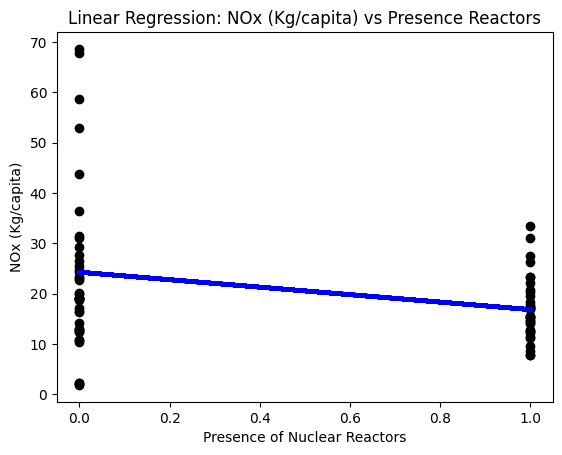

In [ ]:
# splitting the data into features (X) and target variable (y)
X = combined_electricity_pollution_regr['Nuclear_reactors'].values.reshape(-1, 1)
y = combined_electricity_pollution_regr['NOx'].values

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
model = LinearRegression()

# fitting the model on the training data
model.fit(X_train, y_train)

# making predictions on the test data
y_pred = model.predict(X_test)

# calculating and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# plotting the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Presence of Nuclear Reactors')
plt.ylabel('NOx (Kg/capita)')
plt.title('Linear Regression: NOx (Kg/capita) vs Presence Reactors')
plt.show()

Mean Squared Error: 157.71411664839502


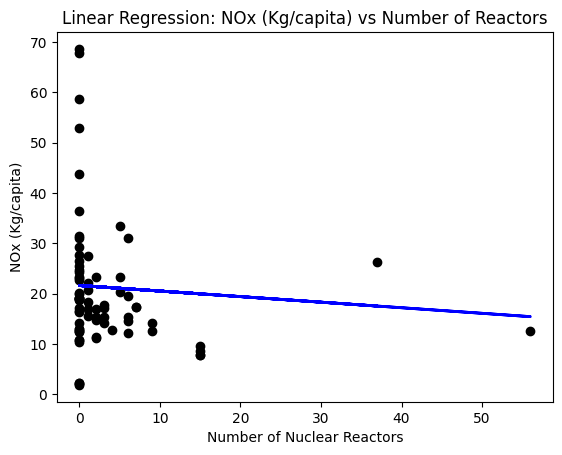

In [ ]:
# splitting the data into features (X) and target variable (y)
X = combined_electricity_pollution_regr['Num_reactors'].values.reshape(-1, 1)
y = combined_electricity_pollution_regr['NOx'].values

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
model = LinearRegression()

# fitting the model on the training data
model.fit(X_train, y_train)

# making predictions on the test data
y_pred = model.predict(X_test)

# calculating and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# plotting the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=2)
plt.xlabel('Number of Nuclear Reactors')
plt.ylabel('NOx (Kg/capita)')
plt.title('Linear Regression: NOx (Kg/capita) vs Number of Reactors')
plt.show()

# **SOx**

The initial observation of a negative correlation finds further support in the initial linear regression. The graph illustrates a clear trend, showcasing lower sulfur oxides (SOx) levels for countries with at least one nuclear reactor. The second regression analysis strengthens this connection, revealing that countries with a higher number of nuclear reactors tend to exhibit lower levels of SOx emissions. The negative correlation is particularly pronounced, with the regression line slope more prominently evident than in the analysis involving NOx as the predictor.

Mean Squared Error: 2457.03378572854


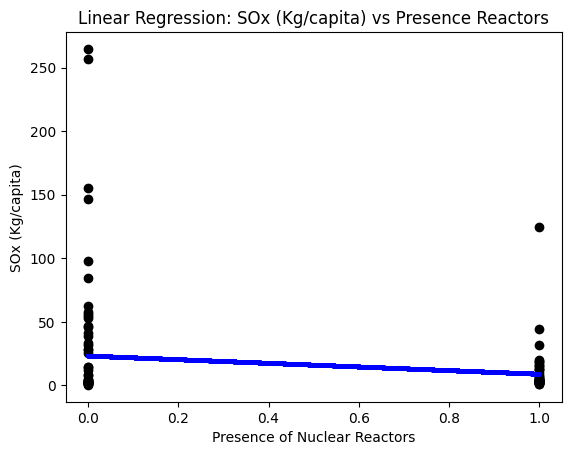

In [ ]:
# splitting the data into features (X) and target variable (y)
X = combined_electricity_pollution_regr['Nuclear_reactors'].values.reshape(-1, 1)
y = combined_electricity_pollution_regr['SOx'].values

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
model = LinearRegression()

# fitting the model on the training data
model.fit(X_train, y_train)

# making predictions on the test data
y_pred = model.predict(X_test)

# calculating and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# plotting the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Presence of Nuclear Reactors')
plt.ylabel('SOx (Kg/capita)')
plt.title('Linear Regression: SOx (Kg/capita) vs Presence Reactors')
plt.show()

Mean Squared Error: 2574.1491354308105


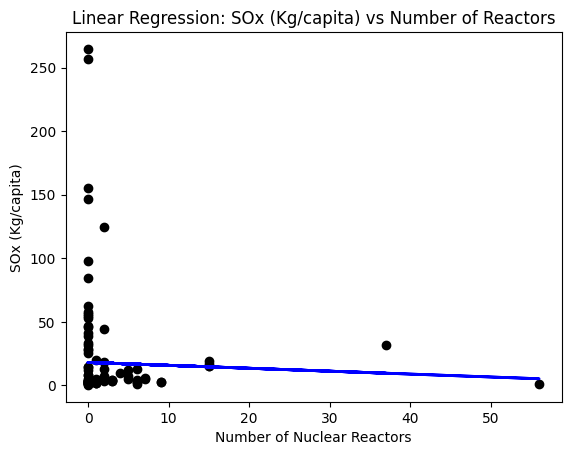

In [ ]:
# splitting the data into features (X) and target variable (y)
X = combined_electricity_pollution_regr['Num_reactors'].values.reshape(-1, 1)
y = combined_electricity_pollution_regr['SOx'].values

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
model = LinearRegression()

# fitting the model on the training data
model.fit(X_train, y_train)

# making predictions on the test data
y_pred = model.predict(X_test)

# calculating and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# plotting the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=2)
plt.xlabel('Number of Nuclear Reactors')
plt.ylabel('SOx (Kg/capita)')
plt.title('Linear Regression: SOx (Kg/capita) vs Number of Reactors')
plt.show()

# **PM 2.5**

The outcomes derived from the linear regression analysis on PM25 support the previous exploratory analysis performed, by displaying a tendency for PM2.5 levels to decrease with the increasing number of nuclear reactors. The negative coefficient in the regression model suggests a potential mitigating effect of nuclear power on particulate matter, indicating a correlation between higher nuclear reactor counts and lower PM2.5 emissions.

Mean Squared Error: 64.14360610195168


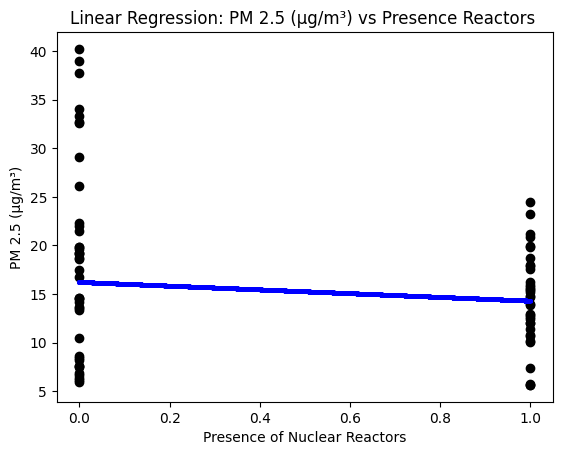

In [ ]:
# splitting the data into features (X) and target variable (y)
X = combined_electricity_pollution_regr['Nuclear_reactors'].values.reshape(-1, 1)
y = combined_electricity_pollution_regr['PM2.5'].values

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
model = LinearRegression()

# fitting the model on the training data
model.fit(X_train, y_train)

# making predictions on the test data
y_pred = model.predict(X_test)

# calculating and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# plotting the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Presence of Nuclear Reactors')
plt.ylabel('PM 2.5 (µg/m³)')
plt.title('Linear Regression: PM 2.5 (µg/m³) vs Presence Reactors ')
plt.show()

Mean Squared Error: 65.32656546392285


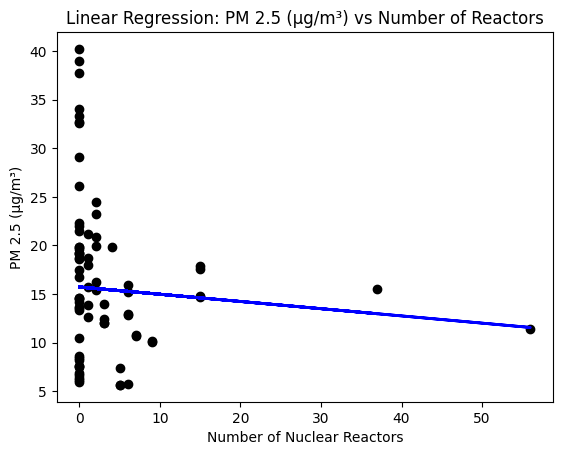

In [ ]:
# splitting the data into features (X) and target variable (y)
X = combined_electricity_pollution_regr['Num_reactors'].values.reshape(-1, 1)
y = combined_electricity_pollution_regr['PM2.5'].values

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
model = LinearRegression()

# fitting the model on the training data
model.fit(X_train, y_train)

# making predictions on the test data
y_pred = model.predict(X_test)

# calculating and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# plotting the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=2)
plt.xlabel('Number of Nuclear Reactors')
plt.ylabel('PM 2.5 (µg/m³)')
plt.title('Linear Regression: PM 2.5 (µg/m³) vs Number of Reactors')
plt.show()

# **CO2**

Unlike the pollutants previously considered, CO2 expresses a positive relationship with the number of reactors, reinforcing the resulting coefficient derived from the heatmap. The slopes of the regression lines, in both cases, are slightly positive, suggesting that the countries with an higher number of reactors seem to be linked to a greater concentration of CO2.
It's crucial to remember that correlation does not imply causation, meaning that the observed positive correlation might not necessarily mean that nuclear reactors directly cause increased CO2 emissions. Other factors and nuances in each country's energy landscape should be considered for a more accurate understanding of the relationship.

Mean Squared Error: 8217706.66207836


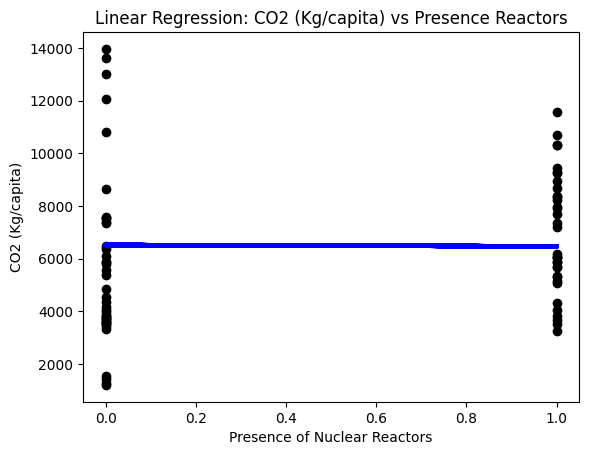

In [ ]:
# splitting the data into features (X) and target variable (y)
X = combined_electricity_pollution_regr['Nuclear_reactors'].values.reshape(-1, 1)
y = combined_electricity_pollution_regr['CO2'].values

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
model = LinearRegression()

# fitting the model on the training data
model.fit(X_train, y_train)

# making predictions on the test data
y_pred = model.predict(X_test)

# calculating and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# plotting the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Presence of Nuclear Reactors')
plt.ylabel('CO2 (Kg/capita)')
plt.title('Linear Regression: CO2 (Kg/capita) vs Presence Reactors')
plt.show()

Mean Squared Error: 8179340.587412293


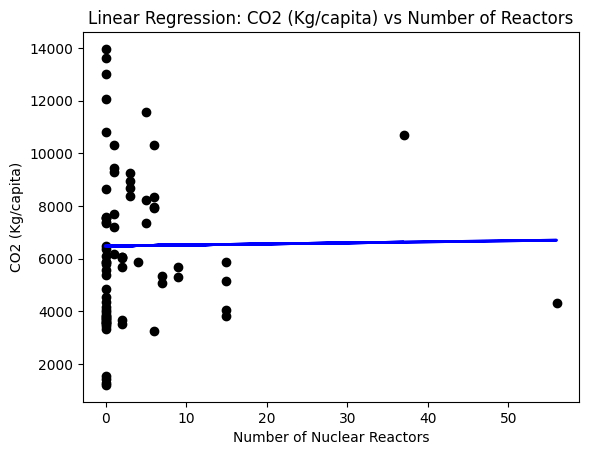

In [ ]:
# splitting the data into features (X) and target variable (y)
X = combined_electricity_pollution_regr['Num_reactors'].values.reshape(-1, 1)
y = combined_electricity_pollution_regr['CO2'].values

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
model = LinearRegression()

# fitting the model on the training data
model.fit(X_train, y_train)

# making predictions on the test data
y_pred = model.predict(X_test)

# calculating and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# plotting the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=2)
plt.xlabel('Number of Nuclear Reactors')
plt.ylabel('CO2 (Kg/capita)')
plt.title('Linear Regression: CO2 (Kg/capita) vs Number of Reactors')
plt.show()

# **Conclusions:**

The primary goal of this research was to evaluate the causal influence of nuclear power on air pollution emissions in Europe.
Through the above analysis, it is found that the growth of
nuclear power reactors in european countries has a small impact on the changes in the concentrations of selected air pollutants, which is negatively correlated.
The linear regression analyses conducted on various air pollutants, specifically NOx, SOx, PM2.5 and CO2, did not reveal a clear and significant trend associating nuclear energy production with lower pollution levels.
Our main findings suggest that the presence or the increasing number of nuclear reactors had no substantial effects on the overall levels of air pollutants registered.
The resulting research provided slightly more evident negative association between nuclear energy production and 3 of thei air pollutants considered, namely SOx, NOx and PM 2.5, while the regression considering CO2 did not provided the wished significance, showing instead a positive correlation between the pollutant and the number of reactors.
These findings suggest that nuclear energy production may not be a major contributing factor to air pollution, at least within the scope of the examined pollutants. The sustainability of nuclear energy depends on various factors, including safety, waste management, proliferation risks, and economic considerations. While nuclear energy has some attributes that align with sustainability goals, addressing its challenges is crucial for a more comprehensive evaluation of its long-term sustainability.
Moreover, these findings highlight the importance of further
research on the effects of nuclear power on air pollution levels, as well as the need for effective and evidence based air pollution policies.

**A few words about the packages used**



In this Python project, various powerful libraries are imported for data manipulation, analysis, and visualization. Pandas is utilized for efficient data handling, while numpy provides support for numerical operations. Geopandas extends data manipulation capabilities to geospatial data, and Plotly and Matplotlib are employed for creating interactive and static visualizations. The script also includes machine learning functionalities, utilizing Scikit-learn for imputation, linear regression modeling, and performance evaluation. Additionally, the integration of Google Colab facilitates seamless collaboration and execution within the Google Colaboratory environment.